In [38]:
import os

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [42]:
df = pd.read_json('data/translated/sarcasm/sarcasm_headlines_dataset_pl.json')
df

,is_sarcastic,headline,article_link,headline_pl
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,Naukowcy z lat trzydziestych odkrywają zegar z...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,"Reprezentantka rządu USA wyjaśnia, dlaczego Ko..."
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,Jedz warzywa: 9 pysznie różnych przepisów
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,Nieprzyjemna pogoda uniemożliwia kłamcy dotarc...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,"matka jest bardzo blisko użycia słowa ""streami..."
...,...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...,Żydzi świętują Rosh Hashasha czy coś
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...,Śledczy spraw wewnętrznych rozczarowany spiski...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...,Najpiękniejsza przemowa akceptacyjna w tym tyg...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...,Mars zniszczony przez pałac kosmiczny na orbic...


In [43]:
df = df.drop(columns=['article_link', 'headline'])
df = df.iloc[:10000]
df

,is_sarcastic,headline_pl
0,1,Naukowcy z lat trzydziestych odkrywają zegar z...
1,0,"Reprezentantka rządu USA wyjaśnia, dlaczego Ko..."
2,0,Jedz warzywa: 9 pysznie różnych przepisów
3,1,Nieprzyjemna pogoda uniemożliwia kłamcy dotarc...
4,1,"matka jest bardzo blisko użycia słowa ""streami..."
...,...,...
9995,0,Posłuchajcie America: A Huffpost Road Trip
9996,0,"Premiera wideo z ""White Christmas"" Ginger Minj"
9997,0,"Przewodnik pragmatyka, aby wyjść silniejszym p..."
9998,1,Misje „wielkiej kradzieży auto vs” skupiają si...


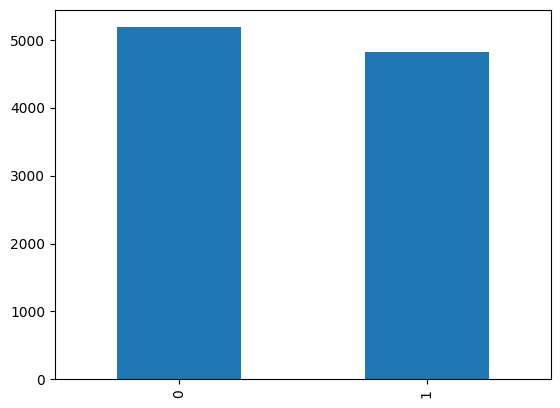

In [44]:
data = df["is_sarcastic"]
data.value_counts().plot.bar()
plt.show()

In [ ]:
!pip install datasets
from datasets import Dataset

raw_dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
raw_dataset

In [ ]:
!pip install transformers
from transformers import AutoTokenizer

checkpoint = "dkleczek/bert-base-polish-uncased-v1"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, model_max_length=512)

In [47]:
def tokenize_function(example):
    return tokenizer(example["headline_pl"], truncation=True)


tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [48]:
# Train set: 80%, Validation set: 10%, Test set: 10%
split_train_val_and_test_dataset = tokenized_dataset.train_test_split(train_size=0.8)
split_val_test_dataset = split_train_val_and_test_dataset["test"].train_test_split(test_size=0.5)

tokenized_train_dataset = split_train_val_and_test_dataset["train"]
tokenized_val_dataset = split_val_test_dataset["train"]
tokenized_test_dataset = split_val_test_dataset["test"]

In [49]:
from transformers import DataCollatorWithPadding

batch_size = 8


def convert_to_tf_dataset(hf_dataset, collator, batch_size=batch_size, shuffle=False):
    return hf_dataset.to_tf_dataset(
        columns=["attention_mask", "input_ids", "token_type_ids"],
        label_cols=["is_sarcastic"],
        collate_fn=collator,
        shuffle=shuffle,
        batch_size=batch_size,
    )


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = convert_to_tf_dataset(hf_dataset=tokenized_train_dataset, collator=data_collator)
tf_val_dataset = convert_to_tf_dataset(hf_dataset=tokenized_val_dataset, collator=data_collator)
tf_test_dataset = convert_to_tf_dataset(hf_dataset=tokenized_test_dataset, collator=data_collator)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [50]:
import sys

import Constants

# Callbacks
training_number = 2
model_name = "sarcasm_pl_bert"
training_folder = f"training_{training_number}"
checkpoint_filename = "cp-{epoch:04d}.ckpt"
training_path = os.path.join(Constants.TRAINING_CHECKPOINTS_PATH, model_name, training_folder)
checkpoint_path = os.path.join(training_path, checkpoint_filename)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)

early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)

In [51]:
checkpoint_path

'../../training_checkpoints/sarcasm_pl_bert/training_2/cp-{epoch:04d}.ckpt'

In [52]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

num_epochs = 10
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

In [54]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [56]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs, callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.7785
Epoch 1: saving model to ../../training_checkpoints/sarcasm_pl_bert/training_2/cp-0001.ckpt
1000/1000 [==============================] - 176s 125ms/step - loss: 0.4683 - accuracy: 0.7785 - val_loss: 0.3953 - val_accuracy: 0.8290
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 0.2307 - accuracy: 0.9101
Epoch 2: saving model to ../../training_checkpoints/sarcasm_pl_bert/training_2/cp-0002.ckpt
1000/1000 [==============================] - 112s 112ms/step - loss: 0.2307 - accuracy: 0.9101 - val_loss: 0.4310 - val_accuracy: 0.8310
Epoch 3/10
1000/1000 [==============================] - ETA: 0s - loss: 0.1133 - accuracy: 0.9575
Epoch 3: saving model to ../../training_checkpoints/sarcasm_pl_bert/training_2/cp-0003.ckpt
1000/1000 [==============================] - 111s 111ms/step - loss: 0.1133 - accuracy: 0.9575 - val_loss: 0.5261 - val_accuracy: 0.8270
Epoch 4/10
1000/100

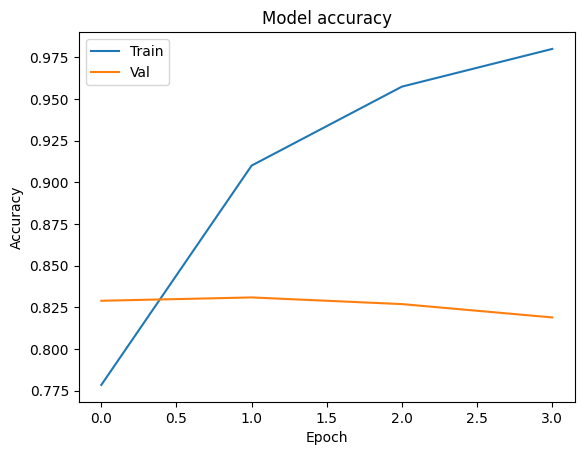

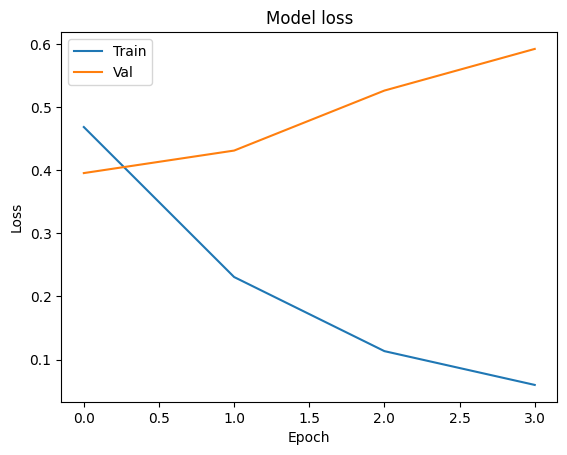

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(f"documentation/models/{model_name}/figures/{training_folder}_accuracy.png")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(f"documentation/models/{model_name}/figures/{training_folder}_loss.png")
plt.show()

In [58]:
import shutil

best_model_checkpoint_index = np.argmin(history.history["val_accuracy"]) + 1
best_model_weights_path = os.path.join(training_path, checkpoint_filename.format(epoch=best_model_checkpoint_index))
best_model = model
best_model.load_weights(best_model_weights_path)

shutil.rmtree(training_path)

In [59]:
saved_model_name = f"{model_name}_{training_number}"

# Save to Saved Model format
best_model.save(os.path.join("trained_models", saved_model_name, Constants.DEFAULT_MODEL_VERSION))

In [60]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=32)

125/125 [==============================] - 6s 50ms/step - loss: 0.5558 - accuracy: 0.8310


[0.5558102130889893, 0.8309999704360962]

In [61]:
# Getting predictions
prediction_logits = best_model.predict(tf_test_dataset)['logits']
probabilities = tf.nn.softmax(prediction_logits)
class_preds = np.argmax(probabilities, axis=1)

125/125 [==============================] - 8s 38ms/step


In [62]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(tokenized_test_dataset['is_sarcastic'], class_preds)
recall = recall_score(tokenized_test_dataset['is_sarcastic'], class_preds)
f1 = f1_score(tokenized_test_dataset['is_sarcastic'], class_preds)

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

Precision score:  0.7980582524271844
Recall score:  0.8634453781512605
F1 score:  0.8294651866801211


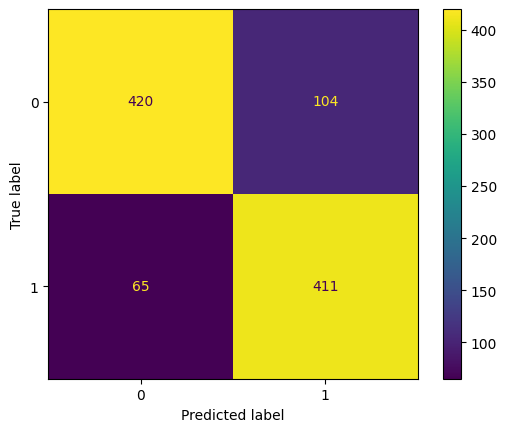

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

result = confusion_matrix(tokenized_test_dataset['is_sarcastic'], class_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=result)
disp.plot()
plt.savefig(f"documentation/models/{model_name}/figures/{training_folder}_confmatrix.png")
plt.show()

In [64]:
bad_prediction_count = 0
predictions_index = 0

while bad_prediction_count < 25 and predictions_index < raw_dataset.num_rows:
    predictions_index += 1

    # if bad prediction then show text and increase count
    if class_preds[predictions_index] != raw_dataset[predictions_index]['is_sarcastic']:
        print(f"""
        BAD PREDICTION:
        - INDEX: {predictions_index}
        - TEXT: {raw_dataset[predictions_index]['headline_pl']}
        - PREDICTED VALUE: {class_preds[predictions_index]}
        - CORRECT VALUE: {raw_dataset[predictions_index]['is_sarcastic']}
        """)
        bad_prediction_count += 1


        BAD PREDICTION:
        - INDEX: 1
        - TEXT: Reprezentantka rządu USA wyjaśnia, dlaczego Kongresowi brakuje równości płci i rasy
        - PREDICTED VALUE: 1
        - CORRECT VALUE: 0
        

        BAD PREDICTION:
        - INDEX: 2
        - TEXT: Jedz warzywa: 9 pysznie różnych przepisów
        - PREDICTED VALUE: 1
        - CORRECT VALUE: 0
        

        BAD PREDICTION:
        - INDEX: 4
        - TEXT: matka jest bardzo blisko użycia słowa "streaming" poprawnie
        - PREDICTED VALUE: 0
        - CORRECT VALUE: 1
        

        BAD PREDICTION:
        - INDEX: 5
        - TEXT: Białe dziedzictwo
        - PREDICTED VALUE: 1
        - CORRECT VALUE: 0
        

        BAD PREDICTION:
        - INDEX: 9
        - TEXT: Wielu rodziców zna ten scenariusz.
        - PREDICTED VALUE: 1
        - CORRECT VALUE: 0
        

        BAD PREDICTION:
        - INDEX: 10
        - TEXT: Ta lesbijka jest uważana za ojca w Indiach (i niesamowita w tym)
        - 

In [65]:
!zip -r documentation.zip documentation/models

updating: documentation/models/ (stored 0%)
updating: documentation/models/.ipynb_checkpoints/ (stored 0%)
updating: documentation/models/sarcasm_pl_bert/ (stored 0%)
updating: documentation/models/sarcasm_pl_bert/figures/ (stored 0%)
updating: documentation/models/sarcasm_pl_bert/figures/training_1_loss.png (deflated 9%)
updating: documentation/models/sarcasm_pl_bert/figures/training_1_accuracy.png (deflated 10%)
updating: documentation/models/sarcasm_pl_bert/figures/training_1_confmatrix.png (deflated 16%)
updating: documentation/models/sarcasm_pl_bert/.ipynb_checkpoints/ (stored 0%)
  adding: documentation/models/sarcasm_pl_bert/figures/training_2_confmatrix.png (deflated 15%)
  adding: documentation/models/sarcasm_pl_bert/figures/training_2_accuracy.png (deflated 11%)
  adding: documentation/models/sarcasm_pl_bert/figures/training_2_loss.png (deflated 9%)


In [66]:
from google.colab import files
files.download("documentation.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>